In [1]:
import sys
import os
sys.path.insert(0,'../classes')
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import logging
import numpy as np

import coloredlogs

from arena import Arena
from coach import Coach
from beck.beck_game import BeckGame as Game
from beck.beck_nnet import NNetWrapper as nn
from beck.beck_players import HumanBeckPlayer
from mcts import MCTS
from utils import *
log = logging.getLogger(__name__)

from keras import backend as K

import tournament
# participant_iters = tournament.participant_iters

participants_dir = '/scratch/zz737/fiar/tournaments/tournament_4' # dir for trained networks
results_dir = '/scratch/zz737/fiar/tournaments/results/tournament_4'
moves_dir = '/scratch/zz737/fiar/tournaments/tournament_4/moves/raw/'
splits_dir = '/scratch/zz737/fiar/tournaments/tournament_4/moves/splits/'

{'mcts100_cpuct1': [1, 2, 3, 4, 6, 7, 9, 11, 12, 16, 18, 21, 25, 28, 29, 30, 37, 38, 39, 45, 47], 'mcts100_cpuct2': [1, 2, 3, 4, 6, 8, 12, 14, 15, 16, 21, 22, 24, 26, 27, 30, 32, 35, 39], 'mcts100_cpuct3': [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 16, 17, 18, 20, 21, 25, 26, 28, 32, 34, 35, 36], 'mcts25_cpuct1': [1, 2, 3, 4, 9, 11, 13, 14, 16, 19, 22, 25, 28, 29, 31, 37, 39, 45, 59, 61], 'mcts50_cpuct1': [1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 17, 18, 20, 21, 23, 25, 28, 29, 31, 37, 39, 41, 44, 45, 47, 48, 53], 'mcts80_cpuct1': [1, 2, 3, 4, 5, 7, 8, 9, 10, 13, 16, 19, 20, 21, 23, 24, 28, 34, 35, 36, 40], 'mcts80_cpuct2': [1, 2, 5, 6, 8, 10, 12, 13, 15, 17, 18, 19, 22, 25, 28, 30, 31, 34, 37, 38, 39, 40, 43, 45, 46, 51], 'mcts80_cpuct3': [1, 2, 5, 6, 7, 9, 12, 13, 14, 19, 21, 22, 23, 24, 26, 27, 28, 35, 36, 42, 43, 47, 49, 50, 51, 53, 54, 55, 56, 57]}
189 participant iterations!


In [2]:
# depth_dir = '/scratch/zz737/fiar/tournaments/tournament_4/depth/checkpoints_mcts100_cpuct2_id-3754964'
depth_dir = '/scratch/zz737/fiar/tournaments/tournament_4/depth/checkpoints_mcts100_cpuct2_id-3752918'


In [3]:
depth_fn_l = os.listdir(depth_dir)
depth_dict={}
for dfn in depth_fn_l:
    model_num, split_i=dfn.split('.')[0].split('_')[-2:]
    if model_num not in depth_dict.keys():
        depth_dict[model_num] = {}
    depth_dict[model_num][split_i] = np.loadtxt(os.path.join(depth_dir,dfn))
# pd.DataFrame(depth_dict)
    

In [4]:
depth_dict = pd.DataFrame(depth_dict).sort_index().sort_index(axis=1,key=lambda x:[int(u) for u in x])

In [5]:
depth_dict_long = pd.melt(depth_dict.loc[:,'3':])

In [6]:
depth_dict_long.variable = depth_dict_long.variable.astype('int')

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
1,2.48021,3.79991,3.46076,3.41217,18.3514,2.77576,7.16551,2.90427,5.94537,1.93165,...,6.55713,3.05274,3.42588,13.7266,3.84969,18.8801,8.34314,8.28745,0.0136994,7.21025
2,5.7261,2.25987,3.54894,7.67526,3.62008,9.04776,6.62145,13.5331,6.08791,7.50726,...,6.04103,2.81758,3.22382,6.4434,6.11118,2.76242,7.86102,0.652025,2.81308,2.26405
3,5.47038,6.04296,2.28293,6.21003,2.86802,7.41748,8.28851,4.19579,6.73046,2.20644,...,2.13958,6.05173,4.74028,8.923,3.07499,3.17171,8.46768,4.58677,4.01848,3.39763
4,0.978511,2.34431,4.91162,14.7932,5.65958,3.55044,0.741226,5.21717,6.02842,2.99686,...,1.88362,3.97103,6.03256,2.21498,11.3723,3.3768,3.24577,10.9057,6.83978,2.51251
5,0.565104,3.14954,8.63172,6.30551,3.44232,5.42105,8.80682,3.59954,6.1087,2.38574,...,1.8068,4.7904,3.75275,6.29312,3.26895,4.51733,8.64445,2.17443,4.55476,6.27249


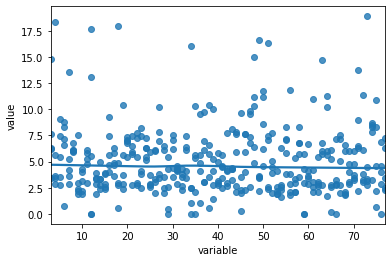

In [32]:
fig,ax = plt.subplots()
sns.regplot(x='variable',y='value',data=depth_dict_long,ax=ax,lowess=True)
depth_dict

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
1,18.0139,7.57645,0.118916,2.2058,2.58256,6.01182,1.22359,7.19535,3.29805,3.37277,...,0.0761948,4.62609,3.43415,19.1821,13.9026,6.59152,15.5421,7.34947,10.7262,10.362
2,2.40591,7.91824,6.72282,13.7186,2.84179,9.0755,1.51623,6.61675,4.4129,5.18721,...,0.696005,4.54951,5.61924,1.34143,16.5646,9.11784,0.616399,1.51963,13.653,1.98389
3,17.7734,6.30476,0.507424,3.5709,5.78807,8.84701,2.78482,4.79723,4.99949,6.38752,...,4.71408,4.52824,3.08583,1.72751,4.10106,10.9565,4.53012,12.1273,4.34838,2.88314
4,1.99212,5.97578,6.64987,3.58214,5.60412,7.81957,2.32475,2.9201,6.71707,9.35361,...,4.71228,5.49513,5.37837,7.01903,6.97008,15.4461,0.676323,2.93435,5.93015,12.4772
5,8.81561,1.92889,0.000383072,11.1476,18.0747,3.27736,1.26003,2.50485,2.08107,6.96821,...,13.3807,2.87125,4.19515,4.53008,17.9847,18.6894,1.94695,0.964338,2.72059,6.6573


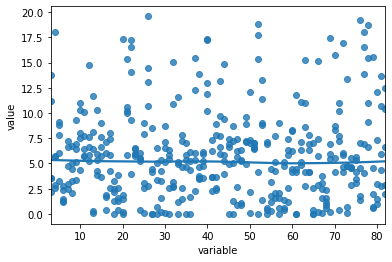

In [7]:
fig,ax = plt.subplots()
sns.regplot(x='variable',y='value',data=depth_dict_long,ax=ax,lowess=True)
depth_dict

In [19]:
result_dir = '/scratch/zz737/fiar/tournaments/results/tournament_4/checkpoints_mcts100_cpuct2_id-3754964'


In [20]:
csv_path = os.path.join(result_dir,'round_robin_combined.csv')

In [27]:
res_df = pd.read_csv(csv_path)
res_df.iloc[:,1:] = res_df.iloc[:,1:].astype(np.float32)

<AxesSubplot:>

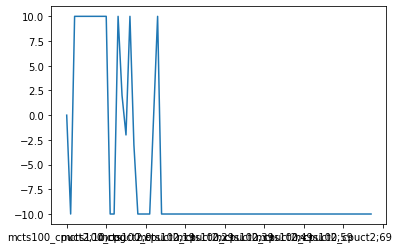

In [30]:
res_df.iloc[0,1:].plot()

<AxesSubplot:>

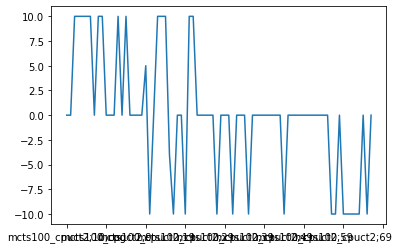

In [31]:
res_df.iloc[1,1:].plot()

In [13]:
sys.path.insert(0,'../classes/')
import tournament_parallel_within_modelclass as tpwm

In [14]:
tpwm.get_participant_iters('checkpoints_mcts100_cpuct2_id-3754964','/scratch/zz737/fiar/tournaments/tournament_4/','/scratch/zz737/fiar/tournaments/results/tournament_4','/scratch/zz737/fiar/tournaments/tournament_4/moves/raw')

['mcts100_cpuct2;10;cog', 'mcts100_cpuct2;50;cog', 'mcts100_cpuct2;1', 'mcts100_cpuct2;2', 'mcts100_cpuct2;3', 'mcts100_cpuct2;4', 'mcts100_cpuct2;5', 'mcts100_cpuct2;6', 'mcts100_cpuct2;7', 'mcts100_cpuct2;8', 'mcts100_cpuct2;9', 'mcts100_cpuct2;10', 'mcts100_cpuct2;11', 'mcts100_cpuct2;12', 'mcts100_cpuct2;13', 'mcts100_cpuct2;14', 'mcts100_cpuct2;15', 'mcts100_cpuct2;16', 'mcts100_cpuct2;17', 'mcts100_cpuct2;18', 'mcts100_cpuct2;19', 'mcts100_cpuct2;20', 'mcts100_cpuct2;21', 'mcts100_cpuct2;22', 'mcts100_cpuct2;23', 'mcts100_cpuct2;24', 'mcts100_cpuct2;25', 'mcts100_cpuct2;26', 'mcts100_cpuct2;27', 'mcts100_cpuct2;28', 'mcts100_cpuct2;29', 'mcts100_cpuct2;30', 'mcts100_cpuct2;31', 'mcts100_cpuct2;32', 'mcts100_cpuct2;33', 'mcts100_cpuct2;34', 'mcts100_cpuct2;35', 'mcts100_cpuct2;36', 'mcts100_cpuct2;37', 'mcts100_cpuct2;38', 'mcts100_cpuct2;39', 'mcts100_cpuct2;40', 'mcts100_cpuct2;41', 'mcts100_cpuct2;42', 'mcts100_cpuct2;43', 'mcts100_cpuct2;44', 'mcts100_cpuct2;45', 'mcts100_cpuc

(['mcts100_cpuct2;10;cog',
  'mcts100_cpuct2;50;cog',
  'mcts100_cpuct2;1',
  'mcts100_cpuct2;2',
  'mcts100_cpuct2;3',
  'mcts100_cpuct2;4',
  'mcts100_cpuct2;5',
  'mcts100_cpuct2;6',
  'mcts100_cpuct2;7',
  'mcts100_cpuct2;8',
  'mcts100_cpuct2;9',
  'mcts100_cpuct2;10',
  'mcts100_cpuct2;11',
  'mcts100_cpuct2;12',
  'mcts100_cpuct2;13',
  'mcts100_cpuct2;14',
  'mcts100_cpuct2;15',
  'mcts100_cpuct2;16',
  'mcts100_cpuct2;17',
  'mcts100_cpuct2;18',
  'mcts100_cpuct2;19',
  'mcts100_cpuct2;20',
  'mcts100_cpuct2;21',
  'mcts100_cpuct2;22',
  'mcts100_cpuct2;23',
  'mcts100_cpuct2;24',
  'mcts100_cpuct2;25',
  'mcts100_cpuct2;26',
  'mcts100_cpuct2;27',
  'mcts100_cpuct2;28',
  'mcts100_cpuct2;29',
  'mcts100_cpuct2;30',
  'mcts100_cpuct2;31',
  'mcts100_cpuct2;32',
  'mcts100_cpuct2;33',
  'mcts100_cpuct2;34',
  'mcts100_cpuct2;35',
  'mcts100_cpuct2;36',
  'mcts100_cpuct2;37',
  'mcts100_cpuct2;38',
  'mcts100_cpuct2;39',
  'mcts100_cpuct2;40',
  'mcts100_cpuct2;41',
  'mcts100_c

In [12]:
csv_path = os.path.join(result_dir,'round_robin_2.csv')
pd.read_csv(csv_path)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/zz737/fiar/tournaments/results/tournament_4/checkpoints_mcts100_cpuct2_id-3754964/round_robin_2.csv'

# params of one instance

In [24]:
dir = '/scratch/zz737/fiar/tournaments/tournament_4/moves/splits/checkpoints_mcts100_cpuct2_id-3752918/1'
p_l = []
for g in range(1,6):
    p = np.loadtxt(os.path.join(dir,f'params{g}.csv'),delimiter=',', dtype='str')
    p_l.append(p)
p_l = pd.DataFrame(p_l,columns=['pruning_thresh','stop_p','feat_drop','lapse','active-passive','center feature','con2','uncon2','3','4'],dtype=np.float32)

p_l.loc['mean'] = p_l.mean(axis=0)
p_l

,pruning_thresh,stop_p,feat_drop,lapse,active-passive,center feature,con2,uncon2,3,4
0,0.19720,0.002797,0.460110,0.276990,1.36510,4.15580,-2.96040,-8.31430,-4.511700,2.951700
1,0.40699,0.032580,0.007920,0.050465,1.18260,-1.95720,4.90140,3.67480,-2.488500,0.802710
2,0.44614,0.001070,0.569190,0.229950,1.46190,3.98580,-3.81480,-3.78920,-9.885400,1.907300
3,0.21480,0.001070,0.450200,0.120180,1.21780,4.78520,-4.04300,-4.43360,-2.519500,2.558600
4,0.19312,0.001754,0.000000,0.050569,0.73895,-9.25900,9.99540,-5.42450,-7.093200,7.272300
mean,0.29165,0.007854,0.297484,0.145631,1.19327,0.34212,0.81572,-3.65736,-5.299661,3.098522


In [25]:
dir = '/scratch/zz737/fiar/tournaments/tournament_4/moves/splits/checkpoints_mcts100_cpuct2_id-3754964/1'
p_l = []
for g in range(1,6):
    p = np.loadtxt(os.path.join(dir,f'params{g}.csv'),delimiter=',', dtype='str')
    p_l.append(p)
p_l = pd.DataFrame(p_l,columns=['pruning_thresh','stop_p','feat_drop','lapse','active-passive','center feature','con2','uncon2','3','4'],dtype=np.float32)
p_l.loc['mean'] = p_l.mean(axis=0)
p_l

,pruning_thresh,stop_p,feat_drop,lapse,active-passive,center feature,con2,uncon2,3,4
0,3.160400,0.008152,0.380780,0.270140,1.122700,5.6125,-0.999140,-3.244200,-2.602700,9.732700
1,0.633770,0.001872,0.468160,0.233690,0.776910,3.6727,-1.301300,-0.818160,-2.917500,7.158100
2,5.112000,0.001135,0.608890,0.104910,1.293300,3.9208,-1.486200,-2.410500,-5.862300,3.142000
3,7.791200,0.039313,0.258590,0.269260,0.968830,7.0859,1.390400,-0.263340,0.039890,5.747800
4,3.889600,0.106120,0.437840,0.340030,1.228200,4.3936,0.919160,-0.673660,-1.949800,4.663700
mean,4.117394,0.031318,0.430852,0.243606,1.077988,4.9371,-0.295416,-1.481972,-2.658482,6.088861


In [16]:
dir = '/scratch/zz737/fiar/tournaments/tournament_4/moves/splits/checkpoints_mcts100_cpuct2_id-3754964/1'
p_l = []
for g in range(1,6):
    p = np.loadtxt(os.path.join(dir,f'params{g}.csv'),delimiter=',', dtype='str')
    p_l.append(p)
pd.DataFrame(p_l,columns=['pruning_thresh','stop_p','feat_drop','lapse','active-passive','center feature','con2','uncon2','3','4'],dtype=np.float32)

,pruning_thresh,stop_p,feat_drop,lapse,active-passive,center feature,con2,uncon2,3,4
0,3.16040,0.008152,0.38078,0.27014,1.12270,5.6125,-0.99914,-3.24420,-2.60270,9.7327
1,0.63377,0.001872,0.46816,0.23369,0.77691,3.6727,-1.30130,-0.81816,-2.91750,7.1581
2,5.11200,0.001135,0.60889,0.10491,1.29330,3.9208,-1.48620,-2.41050,-5.86230,3.1420
3,7.79120,0.039313,0.25859,0.26926,0.96883,7.0859,1.39040,-0.26334,0.03989,5.7478
4,3.88960,0.106120,0.43784,0.34003,1.22820,4.3936,0.91916,-0.67366,-1.94980,4.6637
